## *Statistics coded:* Living conditions in Europe - poverty and social exclusion

Prepared by [**Lasai Barreñada**](https://github.com/LasaiBarrenada) (EMOS).

This notebook aims at illustrating the *Statistics Expplained* article on [Living conditions in Europe - poverty and social exclusion](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_poverty_and_social_exclusion).


### Settings

The libraries needed for this notebook are the following ones:

In [1]:
import numpy as np
import json
import pandas as pd
from eurostatapiclient import EurostatAPIClient
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
import seaborn as sns
import math
from shapely import geometry
import geopandas as gpd
import requests
import io, os, re, sys
import warnings
import copy, functools
import zipfile
import folium
from folium import plugins as foliump
import branca.colormap as bcm

legend_properties = {'weight':'bold','size':'10'}
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany', 'DK':
            'Denmark', 'EE':'Estonia', 'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 'HR':'Croatia', 
            'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT':
            'Malta', 'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 'SE':'Sweden', 'SI':'Slovenia',
            'SK':'Slovakia', 'UK':'United Kingdom', 'EU28': 'EU-28', 'TR':'Turkey','CH':'Switzerland', 'IS':'Iceland', 'MK':'North Macedonia','ME':'Montenegro',
            'NO':'Norway', 'RS': 'Serbia'}
countries_abbr = ['AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI',
                  'FR','HR','HU','IE','IT','LT','LU','LV','NV','NL','PL','PT','RO','SE','SI','SK','UK','MT', 'EU28']

### Documentation:
- [**Numpy**](https://numpy.org/)
- [**EurostatApiClient**](https://pypi.org/project/eurostatapiclient/)
- [**Matplotlib**](https://matplotlib.org/contents.html)
- [**Seaborn**](https://seaborn.pydata.org/)
- [**Math**](https://docs.python.org/3/library/math.html)

#### Set up eurostatapiclinet by supplying settings, which will stay the same throught

In [2]:
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)


In [3]:
def setvaluegraph (value #list of the values 
                   ,axis #Axis where we represent the value
                   , horizontal #True if the graph is horizontal and False if it's vertical 
                   ,xpos = 0 # Parameter to adjust the position of the value on x axis
                   ,ypos= 0 # Parameter to adjust the position of the value on y axis
                   , fontsize= 8
                   , color = 'b'
                   , weight = 'normal'
                   , style = 'normal'
                   , form = '{}'): #Format of the desired value e.g {:.1f}% for pcg
    if horizontal:
         for i,v in enumerate(value):
             axis.text(v-xpos,i-ypos,str(form.format(v)), fontsize = fontsize, color = color, weight = weight, style = style)
    else:
        for i,v in enumerate(value):
            axis.text(i-xpos,v-ypos,str(form.format(v)), fontsize = fontsize, color = color, weight = weight, style = style)
# This function allows to set the value of the represented graph in the graph next to the bar/scatter 

# This function searchs if there is any missing value for a given year and fills it with the most recent existing value within last 2 years
def lastyearvalue (currentdf, #dataframe where we have missing values on the selected year
                   columncurrent, #column of the dataframe with missing values (must be a list)
                   completedf, #dataframe with the info of the previous years
                   year ):#Year of the wanted info (the function will search in the 2 most recent years)
    if len(columncurrent)<1.1: #Checks if we have more than one column of data
             if currentdf[columncurrent].isnull().values.any():
                for i, row in currentdf.iterrows():
                    if math.isnan(row[columncurrent]) :
                         value = completedf[completedf['geo']==str(i) ].iloc[1,0] #Set the value of the year 2017
                         if math.isnan(value):
                             value = completedf[completedf['geo']==str(i) ].iloc[0,0] #Set the value of the year 2016 if 2017 is missing too
                             print('The data of ', i , 'in row ', columncurrent, ' is from ', year-2)
                         else:
                             print('The data of ', i , 'in row ', columncurrent, ' is from ', year-1)

                         currentdf.at[str(i),columncurrent]= value
    else:
            for i, row in currentdf.iterrows():
                for column in columncurrent: #Iterates through all the columns
                    if math.isnan(row[column]):
        
                        value = completedf[(completedf['geo']==str(i)) & (completedf['deg_urb']== column) ].iloc[1,0] #Set the value of the year 2017
                        if math.isnan(value):
                            value = completedf[(completedf['geo']==str(i)) & (completedf['deg_urb']== column) ].iloc[0,0]  #Set the value of the year 2016 if 2017 is missing too
                            print('The data of ', i , 'in row ', column, ' is from ', year-2)
                        else:
                            print('The data of ', i , 'in row ', column, ' is from ', year-1)

                        currentdf.at[str(i),column] = value
def EUorderbystatus (dfmerged): #Creates a order column on the merged df. Caution index must be the countries names
    order = [] #Variable to order the plots in the figure
    for ind in dfmerged.index:
        if ind  =='EU-28':
            order.append(0)
        elif ind  == 'EA19':
               order.append(0)
    #for EU means order 0
        elif ind in ['Switzerland' ,'Norway' , 'Iceland']:
            order.append(2)
    #countries in EEA in third place    
        elif ind in ['North Macedonia' , 'Serbia']:
            order.append(3)
    #countries in procces of accession to EU last place
        elif ind in dfmerged.index.tolist():
            order.append(1)
    #All EU countries + UK in second place
    dfmerged['order']= order

### Poverty and social exclusion

#### Figure 1

Text(0.3, 1, 'People at risk of porverty or social exclusion in EU, 2008-2018 \n (in million persons and % of total population, 2020 data)')

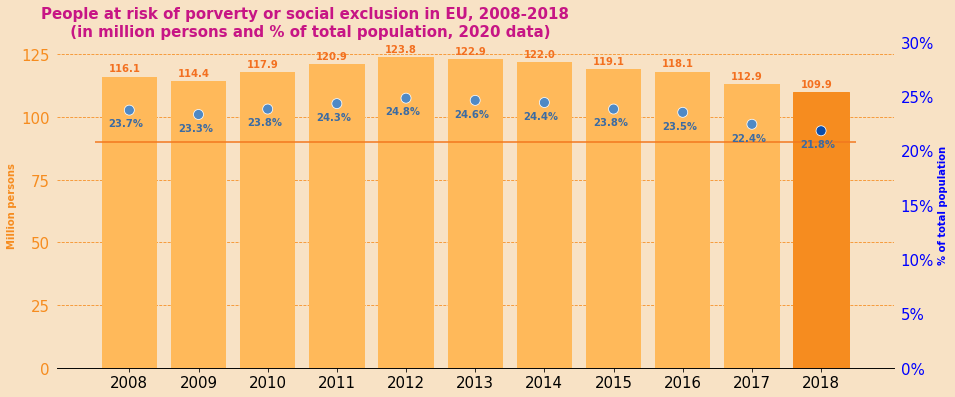

In [4]:
#We define params of dataframes
params_df1_ths_per = {
    'AGE': 'TOTAL',
    'sinceTimePeriod': '2008',
    'sex': 'T',
    'geo':'EU',
    'unit':'THS_PER'
} 
params_df1_pc = {
    'AGE': 'TOTAL',
    'sinceTimePeriod': '2008',
    'sex': 'T',
    'geo':'EU',
    'unit':'PC'
} 
# =============================================================================
# DATA RETRIEVE AND CLEAN SECTION
# =============================================================================
# We retrieve the info with the EurostatApiClient
dataframe_1_ths_per = client.get_dataset('ilc_peps01', params=params_df1_ths_per).to_dataframe()
dataframe_1_pc = client.get_dataset('ilc_peps01', params=params_df1_pc).to_dataframe()
params_df1_ths_per.update({'lastTimePeriod': '2018'})
dataframe_1_ths_per = dataframe_1_ths_per[dataframe_1_ths_per.time <= params_df1_ths_per['lastTimePeriod']]
params_df1_pc.update({'lastTimePeriod': '2018'})
dataframe_1_pc = dataframe_1_pc[dataframe_1_pc.time <= params_df1_pc['lastTimePeriod']]
dataframe_1_ths_per = dataframe_1_ths_per.pivot(index='time', columns='age', values='values').reset_index()
dataframe_1_pc = dataframe_1_pc.pivot(index='time', columns='age', values='values').reset_index()

values = dataframe_1_ths_per['TOTAL']
# =============================================================================
# PLOTTING SECTION
# =============================================================================

fig = plt.figure(facecolor='#f8e2c5', figsize = (15,6)) #We create the figure
ax=fig.add_subplot(facecolor='#f8e2c5')

barplot =ax.bar(dataframe_1_ths_per['time'],dataframe_1_ths_per['TOTAL']/1000, color=('#ffb95a')) #We draw the barplot with the first dataframe
barplot[10].set_color('#f68c1f') #Highlight the 10th bar

axes1 = plt.gca() 
axes2 = axes1.twinx() #We create the secondary axis with twinx
scatterplot= sns.scatterplot(x=dataframe_1_pc['time'], #We draw the scatterplot and specify the arguments
                             y = dataframe_1_pc['TOTAL'],
                             hue= dataframe_1_pc['time'],
                             ax=axes2 ,
                             s = 100 ,
                             palette=['#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#0b4dab'],
                             legend = False)
# We set the ticks of both axis
axes2.set_yticks(range(0,31,5))
axes1.set_yticks(range(0,151,25))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks =  mtick.FormatStrFormatter(fmt)
axes2.yaxis.set_major_formatter(yticks) #We set the ticks of the right axis in percentage
ax.tick_params(axis = "y", which = "both", bottom = False, top = False, left = False, right=False, colors = '#f68c1f' , labelsize = 15)
ax.tick_params(axis ='x', which = 'both', labelsize = 15)
axes2.tick_params(axis='y',right=False, colors = 'b', labelsize = 15)
ax.yaxis.label.set_color('#f68c1f')
ax.set_ylabel('Million persons', weight = 'bold')
axes2.yaxis.label.set_color('b')
axes2.set_ylabel('% of total population' , weight = 'bold')
ax.set_axisbelow(True)

ax.hlines(values[10]/1000-20,-0.5,10.5, colors='#f2771e') #Horizontal line with the last value minus 20 million

#Set the values in the graph with the function defined above
setvaluegraph(round(dataframe_1_ths_per['TOTAL']/1000,1),ax,False,0.3,-2,10,color='#f37020',weight='bold')
setvaluegraph(dataframe_1_pc['TOTAL'],axes2,False,0.3,1.5,10,color='#3b6ba3',weight = 'bold', form ='{:.1f}%' )

ax.grid(True, which = 'major', axis = 'y' , color ='#f68c1f', linestyle = '--' )
sns.despine(top=True, right=True, left=True, bottom=False)

ax.set_title('People at risk of porverty or social exclusion in {}, {}-{} \n (in million persons and % of total population, 2020 data)'.format(params_df1_ths_per['geo'],params_df1_ths_per['sinceTimePeriod'],params_df1_ths_per['lastTimePeriod']),
             fontsize=15,fontweight='bold',y=1, x=0.3, c = 'mediumvioletred')


![Figure 1: People at risk of poverty or social exclusion, 2008-2018(EU-28, million persons)](https://ec.europa.eu/eurostat/statistics-explained/images/f/fe/People_at_risk_of_poverty_or_social_exclusion%2C_2008-2018_2.jpeg)

Figure 1: People at risk of poverty or social exclusion, 2008-2018 (EU-28, million persons)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en))



 # **Figure 2**
![Figure 2: People at risk of poverty or social exclusion by socio-economic characteristic, 2018](https://ec.europa.eu/eurostat/statistics-explained/images/8/80/People_at_risk_of_poverty_or_social_exclusion_by_socio-economic_characteristic%2C_2018_3.png)

Figure 2: People at risk of poverty or social exclusion by socio-economic characteristic, 2018
(% share of the total population)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en))
, ([ilc_peps02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps02&lang=en))
 and ([ilc_peps04](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps04&lang=en))

Text(13.5, 65, 'Activity status')

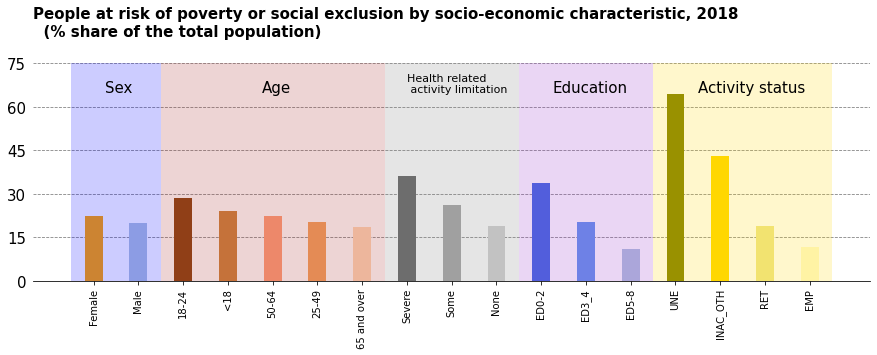

In [5]:


# =============================================================================
# DATA RETRIEVE AND CLEAN SECTION
# =============================================================================

#We set the parameters of the data with the query builder: https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder
dataframe_2_sex_query = 'ilc_peps01?precision=2&sex=F&sex=M&geo=EU&unit=PC&unitLabel=code&time=2018&age=Y_GE18'
dataframe_2_age_query = 'ilc_peps01?precision=1&sex=T&geo=EU&unit=PC&unitLabel=code&time=2018&age=Y18-24&age=Y25-49&age=Y50-64&age=Y_GE65&age=Y_LT18'
dataframe_2_lim_query = 'hlth_dpe010?sex=T&precision=1&lev_limit=NONE&lev_limit=SEV&lev_limit=SOME&geo=EU&unit=PC&time=2018&age=Y_GE16'
dataframe_2_activity_query = 'ilc_peps02?precision=1&sex=T&geo=EU&wstatus=EMP&wstatus=INAC_OTH&wstatus=RET&wstatus=UNE&time=2018&age=Y_GE18'
dataframe_2_education_query = 'ilc_peps04?precision=1&sex=T&geo=EU&isced11=ED0-2&isced11=ED3_4&isced11=ED5-8&time=2018&age=Y_GE18'


dataframe_2_sex = client.get_dataset(dataframe_2_sex_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['F','M'], value = ['Female','Male'] )
dataframe_2_age =client.get_dataset(dataframe_2_age_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['Y18-24','Y_LT18','Y50-64','Y25-49','Y_GE65'],value = ['18-24','<18','50-64','25-49','65 and over'])
dataframe_2_lim =client.get_dataset(dataframe_2_lim_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['SEV','SOME','NONE'], value = ['Severe','Some', 'None'])
dataframe_2_activity =client.get_dataset(dataframe_2_activity_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['ED0-2','ED3_4','ED5-8'],value = ['Low','Medium','High'])
dataframe_2_education =client.get_dataset(dataframe_2_education_query).to_dataframe().sort_values(by = ['values'],ascending = False).replace(to_replace = ['UNE','INAC_OTH','RET','EMP'], value = ['Unemployed','Other inactive','Retired','Employed'])
# =============================================================================
# PLOTTING SECTION
# =============================================================================

#Create the figure
fig, ax = plt.subplots(figsize=(15, 4))
#Plot the bars with the 5 dataframes and set colors
bar_sex = plt.bar(dataframe_2_sex['sex'],dataframe_2_sex['values'], color = ['orange','lightsteelblue'], width = 0.4 )
bar_age = plt.bar(dataframe_2_age['age'],dataframe_2_age['values'], color =['saddlebrown','peru','lightsalmon', 'sandybrown','peachpuff'], width = 0.4  )
bar_lim = plt.bar(dataframe_2_lim['lev_limit'],dataframe_2_lim['values'], color = ['dimgray','darkgray','lightgray'], width = 0.4 )
bar_education = plt.bar(dataframe_2_education['isced11'],dataframe_2_education['values'], color = ['royalblue','cornflowerblue','lightsteelblue'], width = 0.4 )
bar_activity = plt.bar(dataframe_2_activity['wstatus'],dataframe_2_activity['values'], color = ['olive','gold','khaki','lemonchiffon'], width = 0.4 )

ax.set_yticks(range(0,76,15))
ax.tick_params(axis = "y", labelsize = 15, left = False)
sns.despine(top=True, right=True, left=True, bottom=False) #Function that allows to erase the spine
ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--')
ax.set_axisbelow(True) #Function to set the grid below the bars
plt.xticks(rotation= 90)

ax.set_title('People at risk of poverty or social exclusion by socio-economic characteristic, 2018 \n  (% share of the total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.1)

#Set the background color for each group of indicators and text
plt.axvspan(-.5, 1+.5, facecolor='b', alpha=0.2)
plt.axvspan(1.5,6.5, facecolor='brown', alpha=0.2)
plt.axvspan(6.5,9.5, facecolor='grey', alpha=0.2)
plt.axvspan(9.5,12.5, facecolor='darkorchid', alpha=0.2)
plt.axvspan(12.5, 16.5, facecolor='gold', alpha=0.2)
plt.text( 0.25,65,'Sex', fontsize=15)
plt.text(3.75,65,'Age', fontsize=15)
plt.text(7,65,'Health related \n activity limitation', fontsize=11)
plt.text( 10.25,65,'Education', fontsize=15)
plt.text( 13.5,65,'Activity status', fontsize=15)


 # **Figure 3**
![Figure 3: People at risk of poverty or social exclusion by degree of urbanisation, 2018
(% share of the total population)](https://ec.europa.eu/eurostat/statistics-explained/images/2/26/People_at_risk_of_poverty_or_social_exclusion_by_degree_of_urbanisation%2C_2018_2.png)
Figure 3: People at risk of poverty or social exclusion by degree of urbanisation, 2018
(% share of the total population)

Source: Eurostat ([ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en)) and ([ilc_peps13](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps13&lang=en))

The data of  Iceland in row  ['TOTAL']  is from  2017
The data of  Iceland in row  DEG1  is from  2017
The data of  Iceland in row  DEG2  is from  2017
The data of  Iceland in row  DEG3  is from  2017
The data of  Malta in row  DEG3  is from  2016


Text(0, 1.05, 'People at risk of poverty or social exclusion by degree of urbanisation, 2018 \n  (% share of the total population)')

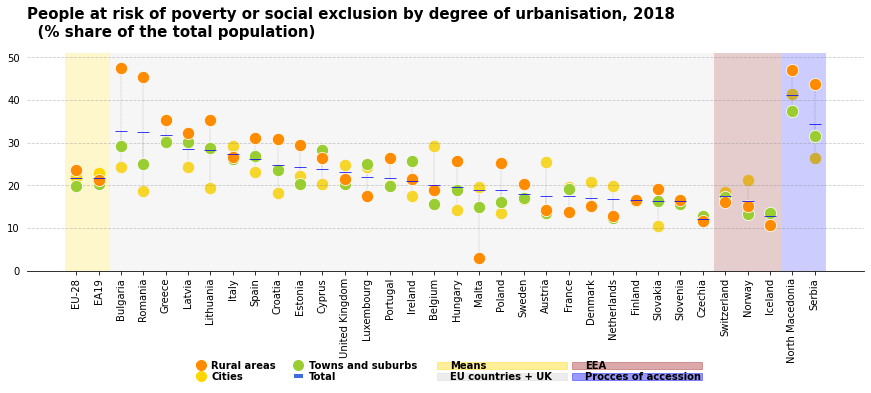

In [6]:

# =============================================================================
# DATA RETRIEVE AND CLEAN SECTION
# =============================================================================
#We set the parameters of the data with the query builder: https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder
dataframe_3_query_total = 'ilc_peps01?precision=1&sex=T&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DK&geo=EA19&geo=EE&geo=EL&geo=ES&geo=EU28&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=UK&unit=PC&unitLabel=label&time=2018&time=2017&time=2016&age=TOTAL'
dataframe_3_query_urb = 'ilc_peps13?precision=1&deg_urb=DEG1&deg_urb=DEG2&deg_urb=DEG3&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DE&geo=DK&geo=EA19&geo=EE&geo=EL&geo=ES&geo=EU28&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=UK&unit=PC&unitLabel=label&time=2018&time=2017&time=2016'


dataframe_3_total = client.get_dataset(dataframe_3_query_total).to_dataframe().replace({'geo':countries_names})
dataframe_3_total_2018 = dataframe_3_total[dataframe_3_total['time']=='2018'].pivot(index = 'geo', columns = 'age', values = 'values') #We get the data of just 2018 and index by country with just the values to plot
dataframe_3_urb = client.get_dataset(dataframe_3_query_urb).to_dataframe().replace({'geo':countries_names})
dataframe_3_urb_2018 = dataframe_3_urb.loc[dataframe_3_urb['time']=='2018'].pivot(index = 'geo', columns = 'deg_urb', values = 'values') #We get the data of just 2018 and index by country with just the values to plot

lastyearvalue(dataframe_3_total_2018,['TOTAL'],dataframe_3_total, 2018) #We search and replace if there is any missing value in 2018 with the data of 2017 and 2016

deg = ['DEG1','DEG2','DEG3'] #Create a list in order to pass in the lastyearvalue function with all the columns to check
lastyearvalue(dataframe_3_urb_2018, deg,dataframe_3_urb, 2018) #We search and replace if there is any missing value in 2018 with the data of 2017 and 2016

dataframe_3_merged = dataframe_3_total_2018.join(dataframe_3_urb_2018).sort_values(by = ['TOTAL'],ascending = False) #Join the 2 dataframes to simplify the data

EUorderbystatus(dataframe_3_merged)
dataframe_3_merged_sorted = dataframe_3_merged.sort_values(['order','TOTAL'],ascending = [True,False]) #Sort the data by order variable and then by its TOTAL
# =============================================================================
# PLOTTING SECTION
# =============================================================================
fig, ax = plt.subplots(figsize=(15, 4))

plt.ylim(0,51)


sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['DEG1'],
                             s = 150 ,       
                             legend = False,
                             color = 'gold',
                             zorder = 1) #Specify the order of the drawing to keep the total value in front
sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['DEG2'],
                             s = 150 ,       
                             legend = False,
                             color='yellowgreen',
                             zorder = 2)
sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['DEG3'],
                             s = 150 ,       
                             legend = False,
                             color='darkorange',
                              zorder = 3)
scatterplot= sns.scatterplot(x=dataframe_3_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_3_merged_sorted['TOTAL'],
                             ax=ax ,
                             s = 150 ,
                             legend = False,
                             marker="_",
                             color = 'b', 
                              zorder = 4)
for point in dataframe_3_merged_sorted.drop(['order'], axis = 1):
    plt.vlines(dataframe_3_merged_sorted.index, dataframe_3_merged_sorted[point],dataframe_3_merged_sorted['TOTAL'], lw = 0.3, color = 'gray', zorder = 0, ls = '--') #Draw lines from the points to total
sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.tick_params(axis = "x", rotation = 90)
ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--', alpha = 0.4)

ax.set_ylabel('')
ax.set_xlabel('')

#Set the background color for each group of countries
plt.axvspan(-0.5,1.5, facecolor='gold', alpha=0.2)
plt.axvspan(1.5, 31.5,facecolor='lightgray', alpha=0.2)
plt.axvspan(28.5,31.5, facecolor='brown', alpha=0.2)
plt.axvspan(31.5, 33.5, facecolor='b', alpha=0.2)

#Create the legend with Lines and Patches
gold_point = Line2D([0], [0],lw = 4, color = 'gold', label='Cities', marker = 'o', markersize=10)
blue_line =Line2D([0], [0],lw = 4,color='royalblue', label='Total')
orange_point =Line2D([0], [0],lw = 4,color='darkorange', label='Rural areas', marker = 'o', markersize=10)
green_point = Line2D([0], [0],lw = 4,color='yellowgreen', label='Towns and suburbs', marker = 'o', markersize=10)
gold_patch = mpatches.Patch(color='gold', label='Means')
blue_patch = mpatches.Patch(color='b', label='Procces of accession')
grey_patch = mpatches.Patch(color='lightgray', label='EU countries + UK')
brown_patch = mpatches.Patch(color='brown', label='EEA')

leg= ax.legend(handles=[orange_point,gold_point, green_point,blue_line, gold_patch, grey_patch, brown_patch, blue_patch],frameon=False, loc=(0.20, -0.53), ncol=4, prop=legend_properties,labelspacing=0.1, handlelength=0.5)

for patch in leg.get_patches():
    patch.set_width(130)
    patch.set_alpha(0.4)
ax.set_title('People at risk of poverty or social exclusion by degree of urbanisation, 2018 \n  (% share of the total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)



# **Figure 4**
![Figure 4: People at risk of poverty or social exclusion by type of risk, EU-28, 2018 (million persons)](https://ec.europa.eu/eurostat/statistics-explained/images/3/3d/People_at_risk_of_poverty_or_social_exclusion_by_type_of_risk%2C_EU-28%2C_2018_3.png)

Figure 4: People at risk of poverty or social exclusion by type of risk, EU-28, 2018 (million persons)

Source: Eurostat ([ilc_pees01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_pees01&lang=en))

# **Figure 5**
![Figure 5: People at risk of poverty or social exclusion by type of risk, 2018(% share of the total population)
](https://ec.europa.eu/eurostat/statistics-explained/images/4/4a/People_at_risk_of_poverty_or_social_exclusion_by_type_of_risk%2C_2018_2.png)
Figure 5: People at risk of poverty or social exclusion by type of risk, 2018(% share of the total population)

Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_pees01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_pees01&lang=en))

Text(0, 1.05, 'People at risk of poverty or social exclusion by type of risk, 2018 \n  (% share of the total population)')

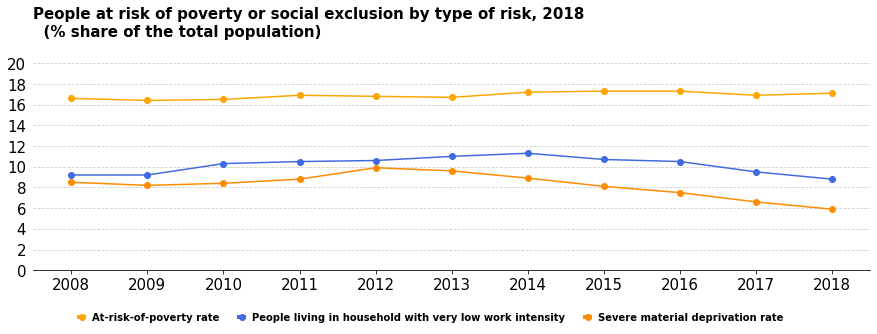

In [7]:
# =============================================================================
# DATA RETRIEVE AND CLEAN SECTION
# =============================================================================

#We set the parameters of the data with the query builder: https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder

dataframe_5_query_total = 'ilc_li02?sinceTimePeriod=2008&precision=1&sex=T&indic_il=LI_R_MD60&unit=PC&age=TOTAL'
dataframe_5_query_lowork = 'ilc_lvhl11?sinceTimePeriod=2008&precision=1&sex=T&geo=EU&unit=PC_Y_LT60&age=Y_LT60'
dataframe_5_query_material = 'ilc_mddd11?sinceTimePeriod=2008&precision=1&sex=T&unit=PC&age=TOTAL'

#We clean the data as in Figure 3 but adding the values by time 
dataframe_5_total =client.get_dataset(dataframe_5_query_total).to_dataframe()
dataframe_5_total =dataframe_5_total.loc[dataframe_5_total['geo'] == 'EU'].pivot(index = 'time',columns = 'age', values = 'values')
dataframe_5_lowork =client.get_dataset(dataframe_5_query_lowork).to_dataframe()
dataframe_5_lowork =dataframe_5_lowork.loc[dataframe_5_lowork['geo'] == 'EU'].dropna().groupby(by = 'time')['values'].sum()
dataframe_5_material = client.get_dataset(dataframe_5_query_material).to_dataframe()
dataframe_5_material =dataframe_5_material.loc[dataframe_5_material['geo'] == 'EU'].dropna().groupby(by = 'time')['values'].sum()
# =============================================================================
# PLOTTING SECTION
# =============================================================================
fig, ax = plt.subplots(figsize=(15, 4))
plt.style.use('default') # Set the aesthetic style of the plots

plt.ylim(0,21)
plt.yticks(np.arange(0, 21, step=2))

#plot the info 
plt.plot(dataframe_5_total,color='orange', marker ='o' )
plt.plot(dataframe_5_lowork, color='royalblue', marker ='o')
plt.plot(dataframe_5_material , color='darkorange', marker ='o')

#Create the artist objects for the legend
gold_line = Line2D([0], [0],lw = 4, color = 'orange', label='At-risk-of-poverty rate', marker ='o')
blue_line =Line2D([0], [0],lw = 4,color='royalblue', label='People living in household with very low work intensity', marker ='o')
orange_line =Line2D([0], [0],lw = 4,color='darkorange', label='Severe material deprivation rate', marker ='o')

leg= ax.legend(handles=[gold_line,blue_line, orange_line],frameon=False, loc=(0.05, -.26), ncol=3, prop=legend_properties,labelspacing=0.1, handlelength=0.5)

ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--', alpha = 0.4)
sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = 'both',which = 'major' , labelsize = 15)
ax.tick_params(axis = "y", left = False)

ax.set_title('People at risk of poverty or social exclusion by type of risk, 2018 \n  (% share of the total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)

The data of  Iceland in row  ['PC']  is from  2017
The data of  Montenegro in row  ['PC']  is from  2017
The data of  Iceland in row  ['EUR']  is from  2017
The data of  Montenegro in row  ['EUR']  is from  2017


Text(0, 1.05, 'At-risk-of-poverty rate and at risk-of-poverty treshold, 2018 \n  (%/thousand PPS)')

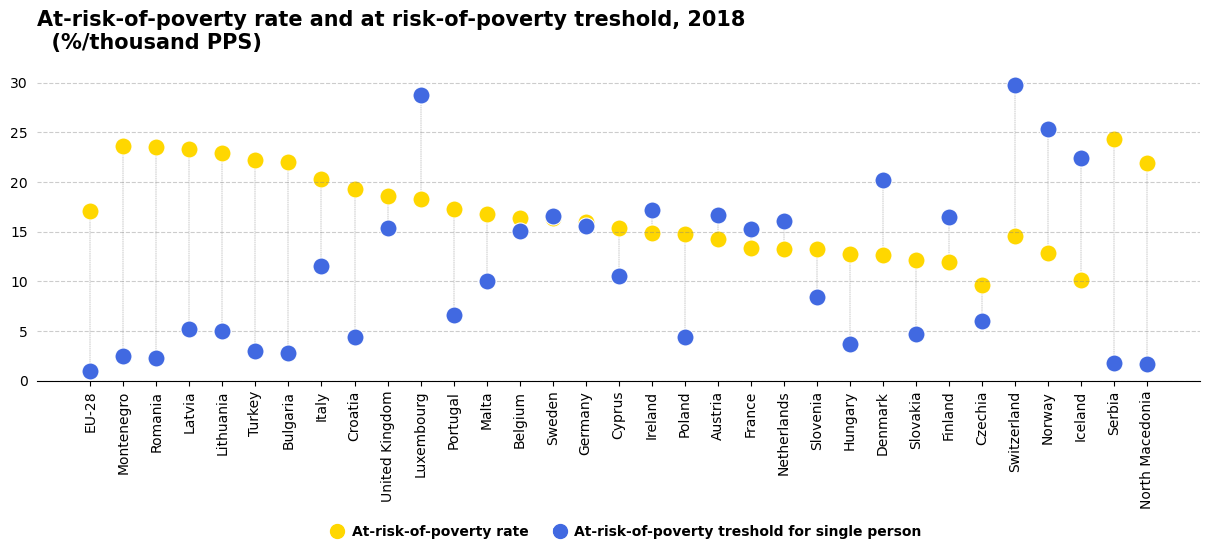

In [8]:
# =============================================================================
# DATA RETRIEVE AND CLEAN SECTION
# =============================================================================
#We set the parameters of the data with the query builder: https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder
dataframe_6_query_rate = 'ilc_li02?precision=1&sex=T&indic_il=LI_R_MD60&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DE&geo=DK&geo=EU28&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=ME&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=TR&geo=UK&unit=PC&time=2016&time=2017&time=2018&age=TOTAL'
dataframe_6_query_treshold = 'ilc_li01?hhtyp=A1&time=2016&time=2017&time=2018&precision=1&indic_il=LI_C_M60&currency=EUR'
#Retrieve and clean data as in figure 3 & 5
dataframe_6_rate =client.get_dataset(dataframe_6_query_rate).to_dataframe().replace({'geo':countries_names})
dataframe_6_rate_2018 = dataframe_6_rate[dataframe_6_rate['time'] == '2018'].pivot(index = 'geo',columns = 'unit', values = 'values')
dataframe_6_treshold = client.get_dataset(dataframe_6_query_treshold).to_dataframe().replace({'geo':countries_names})
dataframe_6_treshold_2018 = dataframe_6_treshold[dataframe_6_treshold['time'] == '2018'].pivot(index = 'geo',columns = 'currency', values = 'values')


lastyearvalue(dataframe_6_rate_2018, ['PC'],dataframe_6_rate, 2018 ) #Check the missing values for 2018
lastyearvalue(dataframe_6_treshold_2018,['EUR'],dataframe_6_treshold, 2018) #Check the missing values for 2018

dataframe_6_treshold_2018 = dataframe_6_treshold_2018.div(1000) #We get the value to plot by dividing by 1000 the treshold dataframe

dataframe_6_merged = dataframe_6_rate_2018.join(dataframe_6_treshold_2018) #Merge both df to simplify
dataframe_6_merged.at['EU-28','EUR']= 1 #We add the value estimated

EUorderbystatus(dataframe_6_merged) #Order by status in EU
        

dataframe_6_merged_sorted = dataframe_6_merged.sort_values(['order','PC'],ascending = [True,False]).dropna()

# =============================================================================
# PLOTTING SECTION
# =============================================================================
fig, ax = plt.subplots(figsize=(15, 4))
plt.ylim(0,31)

sns.scatterplot(x=dataframe_6_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_6_merged_sorted['PC'],
                             s = 150 ,       
                             legend = False,
                             color = 'gold',
                             zorder = 1)
sns.scatterplot(x=dataframe_6_merged_sorted.index, #We draw the scatterplot and specify the arguments
                             y = dataframe_6_merged_sorted['EUR'],
                             ax=ax ,
                             s = 150 ,
                             legend = False,
                             color = 'royalblue', 
                              zorder = 4)

for point in dataframe_6_merged_sorted.drop(['order'], axis = 1): #draw lines from one scatter to another
     plt.vlines(dataframe_6_merged_sorted.index, dataframe_6_merged_sorted[point],dataframe_6_merged_sorted['EUR'], lw = 0.3, color = 'gray', zorder = 0, ls = '--')

sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.tick_params(axis = "x", rotation = 90)

ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--', alpha = 0.4)

ax.set_ylabel('')
ax.set_xlabel('')

#Create custom legend
gold_point = Line2D([0], [0],lw = 4, color = 'gold', label='At-risk-of-poverty rate', marker = 'o', markersize=10)
blue_point =Line2D([0], [0],lw = 4,color='royalblue', label='At-risk-of-poverty treshold for single person', marker = 'o', markersize=10)

leg= ax.legend(handles=[gold_point, blue_point],frameon=False, loc=(0.25, -0.53), ncol=2, prop=legend_properties,labelspacing=0.1, handlelength=0.5)
ax.set_title('At-risk-of-poverty rate and at risk-of-poverty treshold, 2018 \n  (%/thousand PPS)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)

# **Figure 6**
![Figure 6: At-risk-of-poverty rate and at-risk-of-poverty threshold, 2018 (% / thousand PPS)
](https://ec.europa.eu/eurostat/statistics-explained/images/e/ec/At-risk-of-poverty_rate_and_at-risk-of-poverty_threshold%2C_2018.png)
Figure 6: At-risk-of-poverty rate and at-risk-of-poverty threshold, 2018 (% / thousand PPS)

Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li01&lang=en))
# **Figure 7**
![Figure 7: At-risk-of-poverty rate - before and after - deducting housing costs, 2018 (% share of total population)](https://ec.europa.eu/eurostat/statistics-explained/images/0/05/At-risk-of-poverty_rate_-_before_and_after_-_deducting_housing_costs%2C_2018.png)
Figure 7: At-risk-of-poverty rate - before and after - deducting housing costs, 2018 (% share of total population)
Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li48](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li48&lang=en))

The data of  Iceland in row  ['PC']  is from  2017
The data of  Montenegro in row  ['PC']  is from  2017
The data of  Iceland in row  ['TOTAL']  is from  2017


Text(0, 1.05, 'At-risk-of-poverty rate - before and after - deducting housing costs, 2018 \n  (% share of total population)')

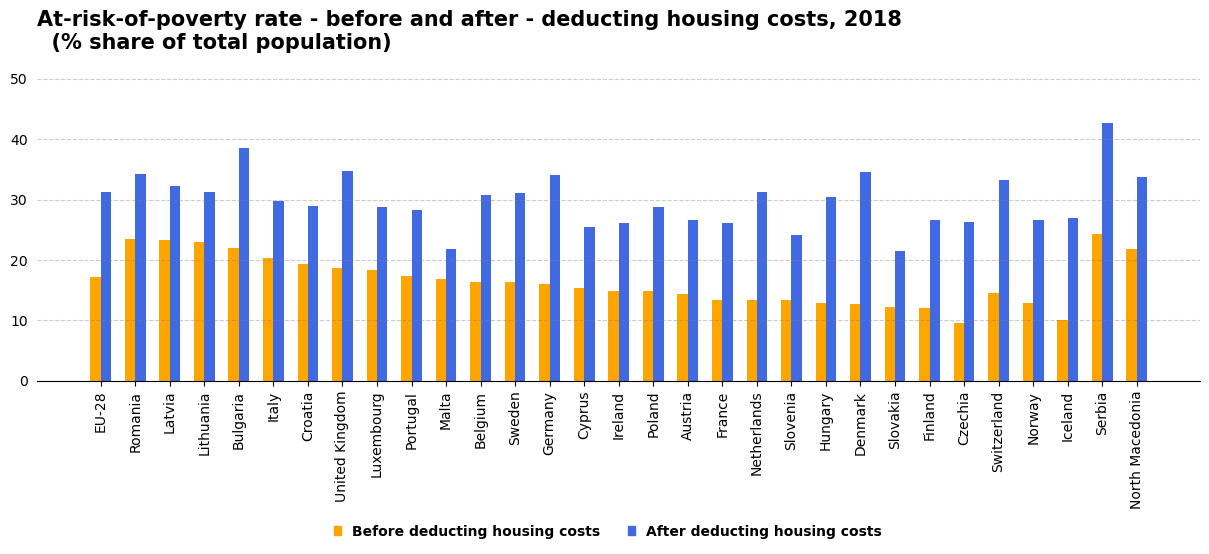

In [9]:
# =============================================================================
# DATA RETRIEVE AND CLEAN SECTION
# =============================================================================

#We set the parameters of the data with the query builder: https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder
dataframe_7_query_before = 'ilc_li02?precision=1&sex=T&indic_il=LI_R_MD60&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DE&geo=DK&geo=EU28&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=ME&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=TR&geo=UK&unit=PC&time=2016&time=2017&time=2018&age=TOTAL'
dataframe_7_query_after = 'ilc_li48?precision=1&deg_urb=TOTAL&time=2016&time=2017&time=2018'

dataframe_7_before =client.get_dataset(dataframe_7_query_before).to_dataframe().replace({'geo':countries_names})
dataframe_7_before_2018 = dataframe_7_before[dataframe_7_before['time'] == '2018'].pivot(index = 'geo',columns = 'unit', values = 'values')


dataframe_7_after =client.get_dataset(dataframe_7_query_after).to_dataframe().replace({'geo':countries_names})
dataframe_7_after_2018 = dataframe_7_after[dataframe_7_after['time'] == '2018'].pivot(index = 'geo',columns = 'deg_urb', values = 'values')

lastyearvalue(dataframe_7_before_2018,['PC'],dataframe_7_before,2018)
lastyearvalue(dataframe_7_after_2018,['TOTAL'],dataframe_7_after,2018)

dataframe_7_merged = dataframe_7_before_2018.join(dataframe_7_after_2018) #Merge both df to simplify

EUorderbystatus(dataframe_7_merged) #Order by status in EU

dataframe_7_merged_sorted = dataframe_7_merged.sort_values(['order','PC'],ascending = [True,False]).dropna()
# =============================================================================
# PLOTTING SECTION
# =============================================================================

fig, ax = plt.subplots(figsize=(15, 4))

plt.ylim(0,51)

x = np.arange(len(dataframe_7_merged_sorted))
width = 0.3 #Use width to create 2 bar charts in the same axis one next to the other

bar_before = ax.bar(x - width/2,dataframe_7_merged_sorted['PC'], width, color = 'orange')
bar_after = ax.bar(x + width/2,dataframe_7_merged_sorted['TOTAL'], width, color = 'royalblue')
plt.xticks(x)
labels = dataframe_7_merged_sorted.index.values.tolist()
ax.set_xticklabels(labels, rotation = 90) #Set the labels of the x axis as the countries

sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--', alpha = 0.4, zorder = 0)

#Create custom legend
gold_patch = mpatches.Patch(color='orange', label='Before deducting housing costs')
blue_patch = mpatches.Patch(color='royalblue', label='After deducting housing costs')
leg= ax.legend(handles=[gold_patch, blue_patch],frameon=False, loc=(0.25, -0.53), ncol=2, prop=legend_properties,labelspacing=0.1, handlelength=0.5)

#Set custom tittle
ax.set_title('At-risk-of-poverty rate - before and after - deducting housing costs, 2018 \n  (% share of total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)

# **Figure 8**
![Figure 8: At-risk-of-poverty rate - before and after - social transfers, 2018 (% share of total population)
](https://ec.europa.eu/eurostat/statistics-explained/images/f/fe/At-risk-of-poverty_rate_-_before_and_after_-_social_transfers%2C_2018.png)
Figure 8: At-risk-of-poverty rate - before and after - social transfers, 2018 (% share of total population)
Source: Eurostat ([ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en)) and ([ilc_li10](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li10&lang=en))

The data of  Iceland in row  ['PC']  is from  2017
The data of  Montenegro in row  ['PC']  is from  2017
The data of  EU15 in row  ['TOTAL']  is from  2017
The data of  EU25 in row  ['TOTAL']  is from  2016
The data of  Iceland in row  ['TOTAL']  is from  2016
The data of  Montenegro in row  ['TOTAL']  is from  2016
The data of  NMS10 in row  ['TOTAL']  is from  2016


Text(0, 1.05, 'At-risk-of-poverty rate - before and after - social transfers, 2018 \n  (% share of total population)')

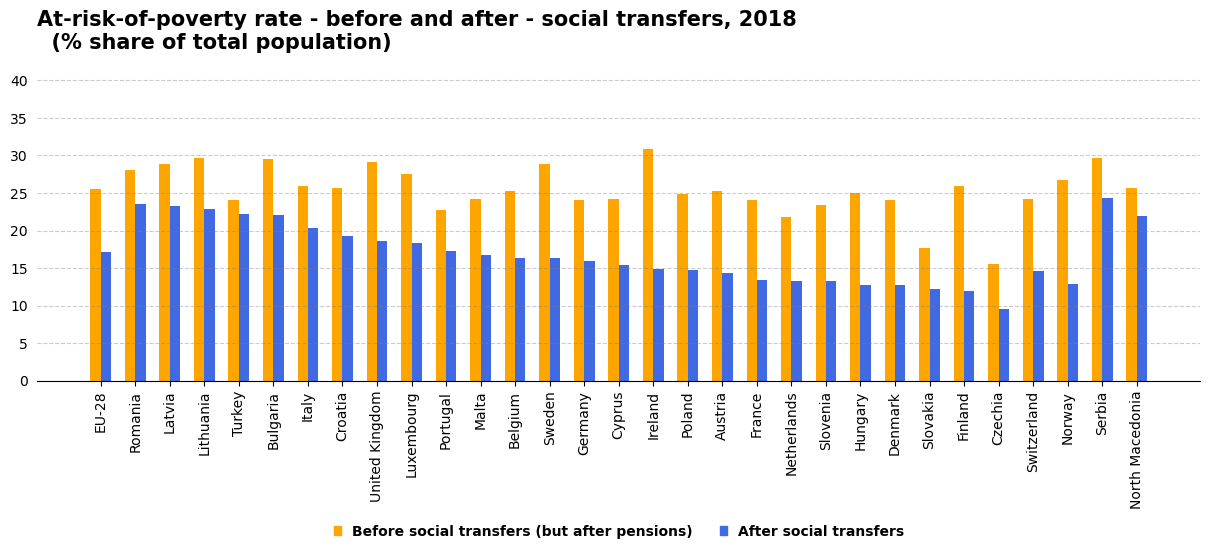

In [10]:
# =============================================================================
# DATA RETRIEVE AND CLEAN SECTION
# =============================================================================

#We set the parameters of the data with the query builder: https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder
dataframe_8_query_after = 'ilc_li02?precision=1&sex=T&indic_il=LI_R_MD60&geo=AT&geo=BE&geo=BG&geo=CH&geo=CY&geo=CZ&geo=DE&geo=DK&geo=EU28&geo=FI&geo=FR&geo=HR&geo=HU&geo=IE&geo=IS&geo=IT&geo=LT&geo=LU&geo=LV&geo=ME&geo=MK&geo=MT&geo=NL&geo=NO&geo=PL&geo=PT&geo=RO&geo=RS&geo=SE&geo=SI&geo=SK&geo=TR&geo=UK&unit=PC&time=2016&time=2017&time=2018&age=TOTAL'
dataframe_8_query_before = 'ilc_li10?precision=1&sex=T&indic_il=LI_R_MD60BT&age=TOTAL'

dataframe_8_after =client.get_dataset(dataframe_8_query_after).to_dataframe().replace({'geo':countries_names})
dataframe_8_after_2018 = dataframe_8_after[dataframe_8_after['time'] == '2018'].pivot(index = 'geo',columns = 'unit', values = 'values')

dataframe_8_before =client.get_dataset(dataframe_8_query_before).to_dataframe().replace({'geo':countries_names})
dataframe_8_before_2018 = dataframe_8_before[dataframe_8_before['time'] == '2018'].pivot(index = 'geo',columns = 'age', values = 'values')

lastyearvalue(dataframe_8_after_2018,['PC'],dataframe_8_after,2018)
lastyearvalue(dataframe_8_before_2018,['TOTAL'],dataframe_8_before,2018)

dataframe_8_merged = dataframe_8_after_2018.join(dataframe_8_before_2018) #Merge both df to simplify

EUorderbystatus(dataframe_8_merged) #Order by status in EU

dataframe_8_merged_sorted = dataframe_8_merged.sort_values(['order','PC'],ascending = [True,False]).dropna()

fig, ax = plt.subplots(figsize=(15, 4))

plt.ylim(0,41)

x = np.arange(len(dataframe_8_merged_sorted))
width = 0.3 #Use width to create 2 bar charts in the same axis one next to the other


bar_after = ax.bar(x + width/2,dataframe_8_merged_sorted['PC'], width, color = 'royalblue')
bar_before = ax.bar(x - width/2,dataframe_8_merged_sorted['TOTAL'], width, color = 'orange')


plt.xticks(x)

labels = dataframe_8_merged_sorted.index.values.tolist()
ax.set_xticklabels(labels, rotation = 90) #Set the labels of the x axis as the countries
sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.grid(True, which = 'major', axis = 'y' , color ='grey', linestyle = '--', alpha = 0.4, zorder = 0)

#Create custom legend
gold_patch = mpatches.Patch(color='orange', label='Before social transfers (but after pensions)')
blue_patch = mpatches.Patch(color='royalblue', label='After social transfers')
leg= ax.legend(handles=[gold_patch, blue_patch],frameon=False, loc=(0.25, -0.53), ncol=2, prop=legend_properties,labelspacing=0.1, handlelength=0.5)

#Set custom tittle
ax.set_title('At-risk-of-poverty rate - before and after - social transfers, 2018 \n  (% share of total population)' 
             , fontsize=15,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)


# **Map 1**
![Map 1: At-risk-of-poverty rate anchored in 2008, 2008-2018 (percentage points difference, 2018 minus 2008)
](https://ec.europa.eu/eurostat/statistics-explained/images/7/7a/AROPE_2019_map1-1.png)

Map 1: At-risk-of-poverty rate anchored in 2008, 2008-2018 (percentage points difference, 2018 minus 2008)

Source: Eurostat ([ilc_li22b](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li22b&lang=en))

### Setting Map

In [11]:
#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [12]:
# We save the direc
_THISDIR_ = !pwd
print('Current working directory: %s' % _THISDIR_)

Current working directory: ['/home/lasai/statistics-coded/popul/living_conditions_poverty_social_exclusion']


In [13]:
# Graph the shape of Europe
# We first select the projection that will be used in this graph
PROJ = 'EPSG:4326'

In [14]:
# We can then integrate the NUTS data [https://nbviewer.jupyter.org/github/eurostat/mortality-viz/blob/master/02_mortality_european_regions.ipynb]
GISCO_DOMAIN = 'https://gisco-services.ec.europa.eu/distribution/v2/'
NUTS_DOMAIN = 'nuts'

NUTS_YEAR = 2021
NUTS_RES = 20 # 60
NUTS_PROJ = PROJ.split(':')[-1] 
NUTS_FMT = 'geojson' # 'topojson'

nuts_template = 'NUTS_RG_%sM_%s_%s_LEVL_%%s.%s' % (NUTS_RES, NUTS_YEAR, NUTS_PROJ, NUTS_FMT) 
nuts_url = '%s/%s/%s' %  (GISCO_DOMAIN, NUTS_DOMAIN, NUTS_FMT)

# https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3857_LEVL_1.geojson
#    'NUTS_RG_%sM_%s_3035_LEVL_%s.%s'

print("Generic URL for NUTS data: \033[1m%s/%s\033[0m (where '%%s' represents a level)" 
      % (nuts_url, nuts_template))

Generic URL for NUTS data: https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2021_4326_LEVL_%s.geojson (where '%s' represents a level)


In [15]:
# We download the different NUTS data (hay cuatro niveles, cada uno de ellos corresponde a una division territorial)

LEVELS = [0,1,2,3]

nuts_files = dict.fromkeys(LEVELS)
nuts_ext = NUTS_FMT

for level in LEVELS:
    nuts_file = nuts_template % level
    nuts_source = '%s/%s' % (nuts_url,nuts_file)
    try : 
        dest = os.path.join(_THISDIR_[0], nuts_file)
        assert os.path.exists(dest)
    except:
        try:
            !wget -O $dest "$nuts_source"
            #!mkdir $nuts_dir
            #!unzip -u -d $nuts_dir $nuts_source        
        except:
            raise IOError("Error fetching the data...")
        else:
            print('Data loaded on disk in directory: \033[1m%s\033[0m' % dest)
    else:
        print('Data already loaded on disk in directory: \033[1m%s\033[0m' % dest)
    finally:
        nuts_files.update({level: nuts_file}) # dest

Data already loaded on disk in directory: /home/lasai/statistics-coded/popul/living_conditions_poverty_social_exclusion/NUTS_RG_20M_2021_4326_LEVL_0.geojson
Data already loaded on disk in directory: /home/lasai/statistics-coded/popul/living_conditions_poverty_social_exclusion/NUTS_RG_20M_2021_4326_LEVL_1.geojson
Data already loaded on disk in directory: /home/lasai/statistics-coded/popul/living_conditions_poverty_social_exclusion/NUTS_RG_20M_2021_4326_LEVL_2.geojson
Data already loaded on disk in directory: /home/lasai/statistics-coded/popul/living_conditions_poverty_social_exclusion/NUTS_RG_20M_2021_4326_LEVL_3.geojson


In [16]:
# We 'store' one vector dataset per NUTS level (nuts_data)

DRIVERS = {'geojson': 'GeoJSON',
          'shp': 'ESRI Shapefile'}

nuts_data = dict.fromkeys(LEVELS)
[nuts_data.update({l: gpd.read_file(os.path.join(_THISDIR_[0], nuts_files[l]), 
                                    driver=DRIVERS[NUTS_FMT])}) 
 for l in LEVELS]

print("Geographical datasets: \033[1m%s\033[0m loaded" % list(nuts_files.values()))
print("Projection: \033[1m%s\033[0m" % nuts_data[LEVELS[0]].crs)

Geographical datasets: ['NUTS_RG_20M_2021_4326_LEVL_0.geojson', 'NUTS_RG_20M_2021_4326_LEVL_1.geojson', 'NUTS_RG_20M_2021_4326_LEVL_2.geojson', 'NUTS_RG_20M_2021_4326_LEVL_3.geojson'] loaded
Projection: epsg:4326


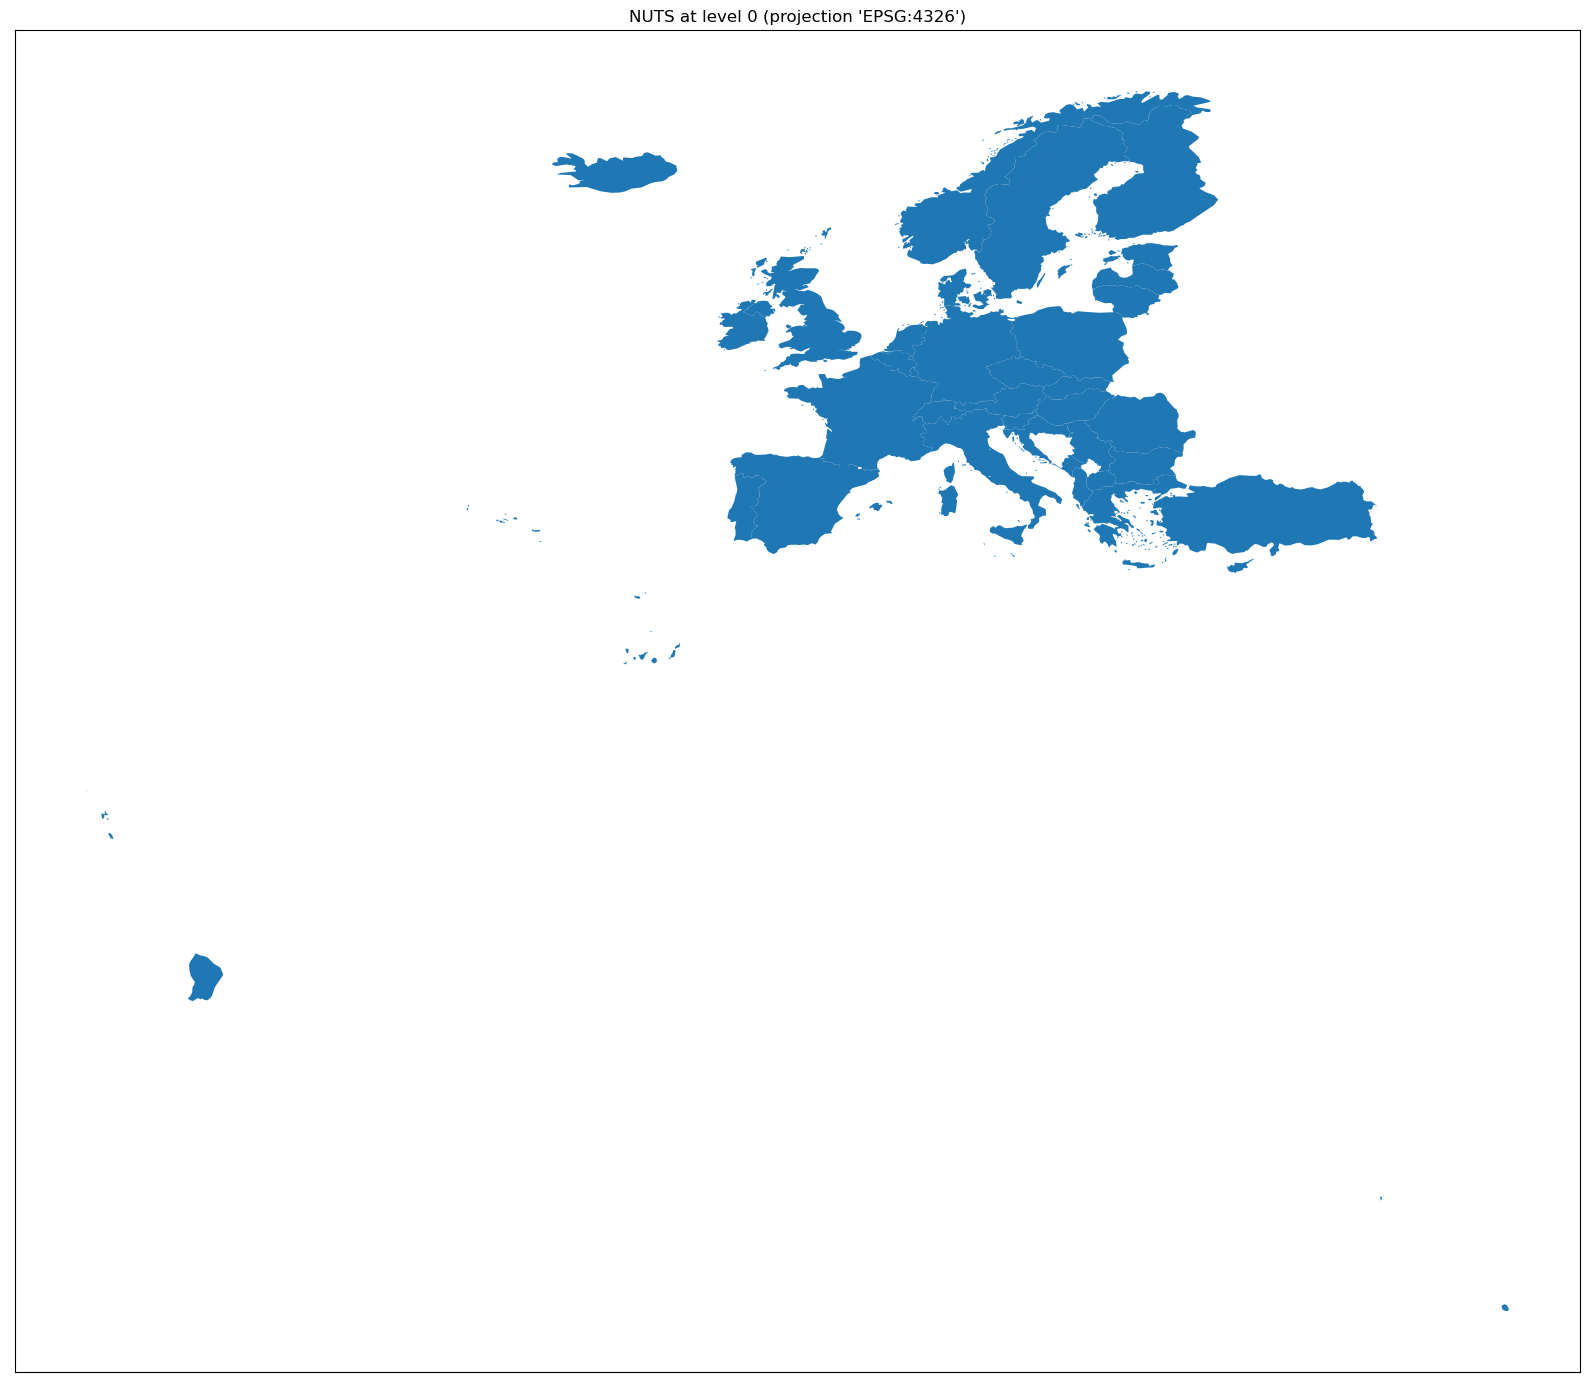

In [17]:
# Map of NUTS data (sin visualizar datos)
level = LEVELS[0]

f, ax = plt.subplots(1, figsize=(16, 16))
nuts_data[level].plot(ax=ax)
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title("NUTS at level %s (projection 'EPSG:%s')" % (level,NUTS_PROJ)) 
f.tight_layout()
plt.show()

In [18]:
# We define query of dataframes from Eurostat query builder

dataframe_map1_query = 'ilc_li22b?precision=1&sex=T&indic_il=LI_R_MD60&unit=PC&time=2008&time=2018&age=TOTAL'
dataframe_map1 =client.get_dataset(dataframe_map1_query).to_dataframe()
dataframe_map1_2008 = dataframe_map1[dataframe_map1['time']=="2008"].pivot(index = 'geo',columns = 'unit', values = 'values')
dataframe_map1_2018 = dataframe_map1[dataframe_map1['time']=="2018"].pivot(index = 'geo',columns = 'unit', values = 'values')
values = dataframe_map1_2018-dataframe_map1_2008

values.sort_values(by = 'PC').head(5)


unit,PC
geo,
RO,-14.0
EE,-11.6
PL,-11.4
TR,-11.2
BG,-10.1


In [19]:
trace = []
colors = []
for value in values['PC']:
    if value< -4.0:
        colors.append('navajowhite')
    elif value< 0.0:
        colors.append('orange')
    elif value< 4:
        colors.append('chocolate')
    elif value >4:
        colors.append('orangered')
    else:
        colors.append('darkgrey')
values['geo'] = values.index.tolist()
values['colors'] = colors

values.head(n = 5)

unit,PC,geo,colors
geo,,,
AT,-3.5,AT,orange
BE,-2.0,BE,orange
BG,-10.1,BG,navajowhite
CH,-3.7,CH,orange
CY,9.6,CY,orangered


In [20]:
# Check which data/countries (DATA_NUTS_ID) are actually made available throughout the dataset
KEY = 'NUTS_ID'

NUTS_ID = dict.fromkeys(LEVELS)
CTRY_ID = dict.fromkeys(LEVELS) 

for l in LEVELS:
    NUTS_ID.update({l: nuts_data[l][KEY].unique().tolist()})
    CTRY_ID.update({l: list(set([_id[:2] for _id in NUTS_ID[l]]))})
    
DATA_NUTS_ID = dict.fromkeys(LEVELS) 
all_id = values['geo'].unique().tolist()

print('Data are availalble:') 
for l in LEVELS:
    DATA_NUTS_ID.update({l: list(set([_id[:2] for _id in all_id if len(_id)==l+2]))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, DATA_NUTS_ID[l]))

Data are availalble:
* NUTS level 0: ['RO', 'FI', 'AT', 'UK', 'NL', 'IE', 'DE', 'PT', 'IS', 'EL', 'BE', 'TR', 'EE', 'DK', 'CY', 'SI', 'LT', 'IT', 'ES', 'FR', 'LV', 'EA', 'SK', 'CZ', 'LU', 'PL', 'BG', 'HU', 'MT', 'EU', 'CH', 'SE', 'NO']
* NUTS level 1: []
* NUTS level 2: ['EA', 'EU']
* NUTS level 3: []


In [21]:
# Check which country/datasets are missing
MISSING_CTRY_ID = dict.fromkeys(LEVELS) 

print('Data are NOT availalble:') 
for l in LEVELS:
    MISSING_CTRY_ID.update({l: list(set(CTRY_ID[l]).difference(set(DATA_NUTS_ID[l])))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, MISSING_CTRY_ID[l]))

Data are NOT availalble:
* NUTS level 0: ['HR', 'AL', 'LI', 'MK', 'ME', 'RS']
* NUTS level 1: ['RO', 'AL', 'FI', 'AT', 'UK', 'NL', 'IE', 'DE', 'PT', 'IS', 'LI', 'EL', 'BE', 'TR', 'EE', 'ME', 'DK', 'CY', 'SI', 'LT', 'IT', 'ES', 'FR', 'LV', 'MK', 'SK', 'CZ', 'LU', 'PL', 'BG', 'RS', 'HR', 'HU', 'MT', 'CH', 'SE', 'NO']
* NUTS level 2: ['RO', 'AL', 'FI', 'AT', 'UK', 'NL', 'IE', 'DE', 'PT', 'LI', 'IS', 'EL', 'BE', 'TR', 'EE', 'ME', 'DK', 'CY', 'SI', 'LT', 'IT', 'LV', 'ES', 'FR', 'MK', 'SK', 'CZ', 'LU', 'PL', 'BG', 'RS', 'HR', 'HU', 'MT', 'CH', 'SE', 'NO']
* NUTS level 3: ['RO', 'AL', 'FI', 'AT', 'UK', 'NL', 'IE', 'DE', 'PT', 'LI', 'IS', 'EL', 'BE', 'TR', 'EE', 'ME', 'DK', 'CY', 'SI', 'LT', 'IT', 'FR', 'ES', 'LV', 'MK', 'SK', 'CZ', 'LU', 'PL', 'BG', 'RS', 'HR', 'HU', 'MT', 'CH', 'SE', 'NO']


In [22]:
# Prepare dataframe to merge the NUTS DATA
values.rename(columns = {'geo':'NUTS_ID'}, inplace = True)
values.head(n = 5)

unit,PC,NUTS_ID,colors
geo,,,
AT,-3.5,AT,orange
BE,-2.0,BE,orange
BG,-10.1,BG,navajowhite
CH,-3.7,CH,orange
CY,9.6,CY,orangered


In [23]:
# We merge NUTS_Data and Dataset_map1
country_data = nuts_data[LEVELS[0]]

# Merge on NUTS_ID
income_nuts = pd.merge(country_data, values, how = 'inner', on = 'NUTS_ID')
income_nuts.head()
colors = income_nuts['colors']

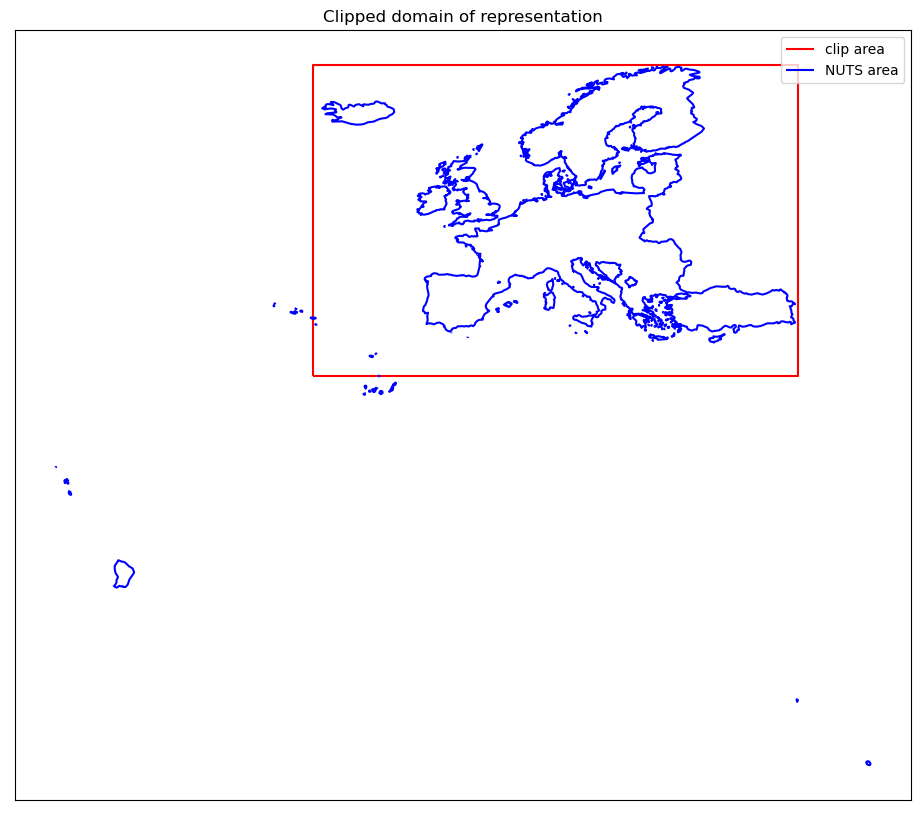

In [24]:
# We define a very coarse bounding box that is embedded in the NUTS bounding box (NUTSarea) so as to render the data in a smaller region
EUmask = geometry.Polygon([#w: -25.5, s:35, e:30.2, n:71.3 in EPSG:4326 system
                         (-25.5, 30.2),
                         (45.3,  30.2),
                         (45.3,  71.3),
                         (-25.5, 71.3)
])
EUclip = gpd.GeoDataFrame(index=[0], geometry=[EUmask], crs=PROJ)

NUTSarea = gpd.GeoDataFrame(index=[0], geometry=[nuts_data[0].unary_union], crs=PROJ)


f, ax = plt.subplots(1, figsize=(16, 10))
EUclip.boundary.plot(ax=ax, color='r', label='clip area')
NUTSarea.boundary.plot(ax=ax, color='b', label='NUTS area')
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('Clipped domain of representation')
ax.legend()
plt.show()

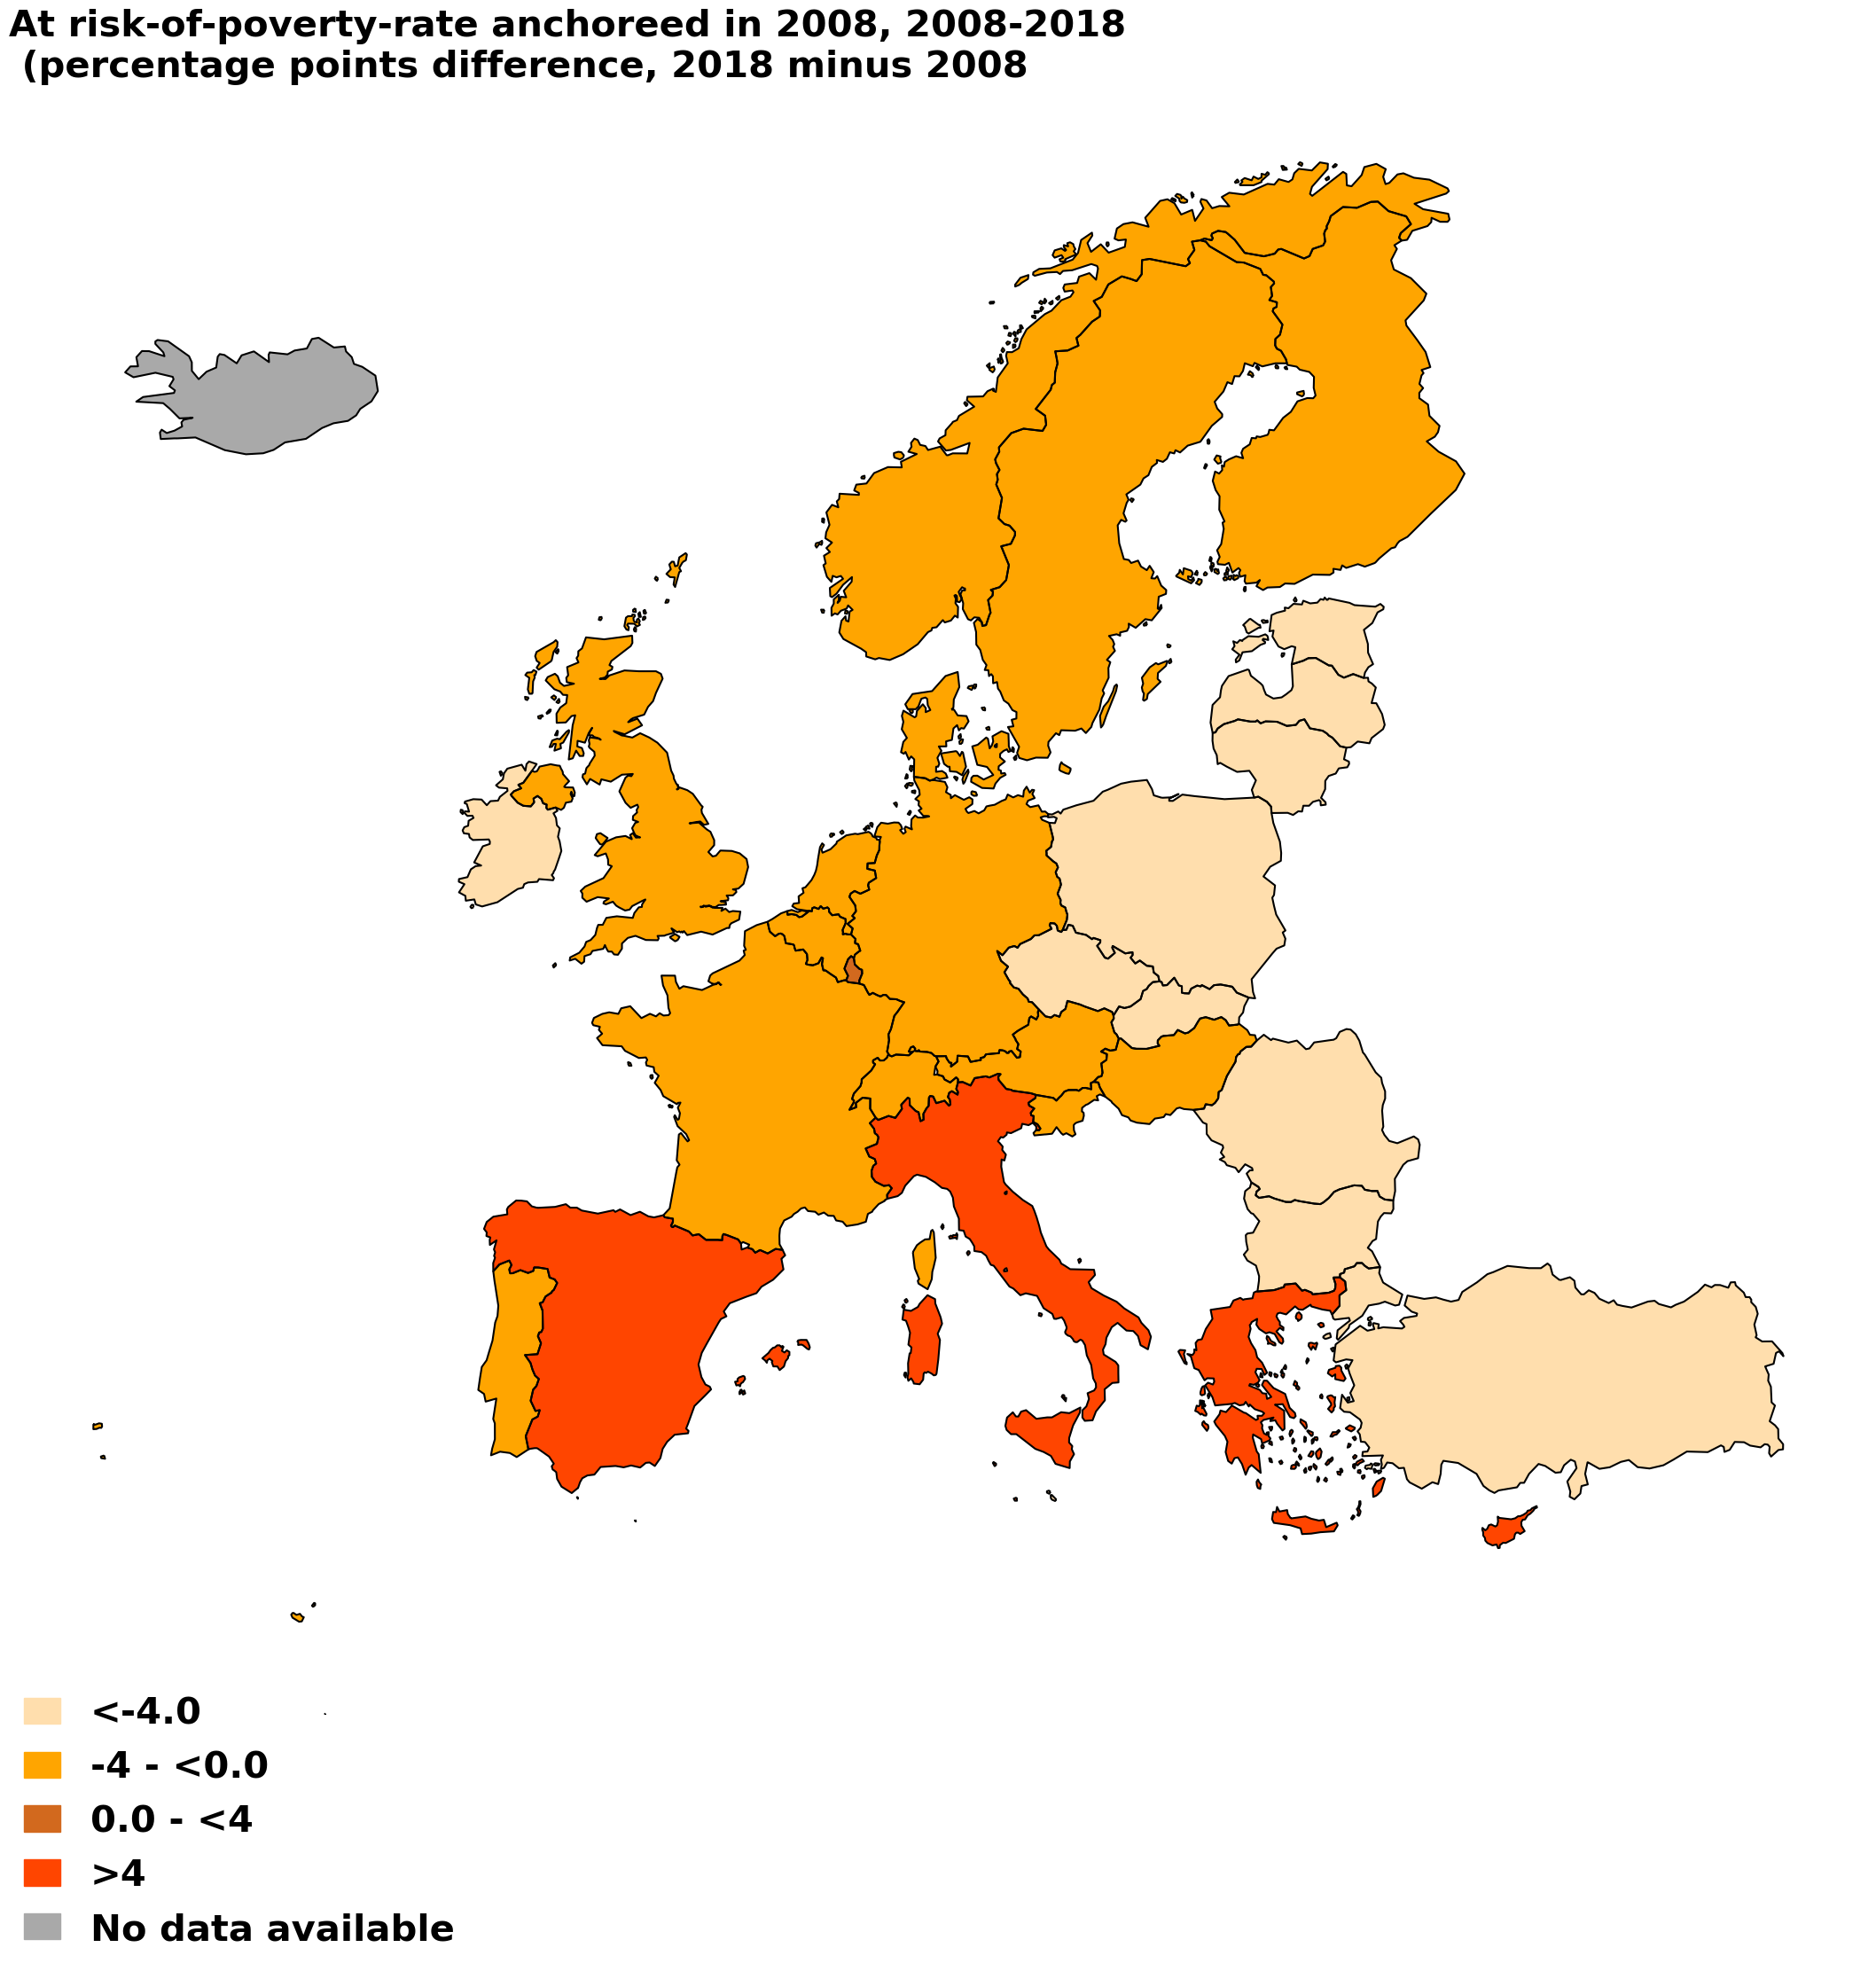

In [36]:
LEVEL = 0
crop = gpd.clip(income_nuts, EUclip)
# crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 

f, ax = plt.subplots(1, figsize=(30, 25))
crop.plot(color=colors,ax=ax,  legend = True,
          legend_kwds = {'shrink':0.55},
          missing_kwds={ "color": "lightgrey", "alpha": 0.2, "edgecolor": "grey", "hatch": "///"}
         )
crop.boundary.plot(ax = ax, color = 'black')
ax.set_axis_off()
ax.set_title('At risk-of-poverty-rate anchoreed in 2008, 2008-2018 \n (percentage points difference, 2018 minus 2008'
             , fontsize=30,fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)
# f.tight_layout()
#f.subplots_adjust(hspace=0,wspace=-1)

#Create custom legend

orange_patch = mpatches.Patch(color='orange', label='-4 - <0.0 ')
orangered_patch = mpatches.Patch(color='orangered', label='>4')
navajowhite_patch = mpatches.Patch(color='navajowhite', label='<-4.0')
darkgrey_patch = mpatches.Patch(color='darkgrey', label='No data available')
chocolate_patch = mpatches.Patch(color='chocolate', label='0.0 - <4')

leg= ax.legend(handles=[navajowhite_patch, orange_patch,chocolate_patch,orangered_patch,darkgrey_patch],frameon=False, loc=(0, -0.1), ncol=1, prop={'weight':'bold','size':'30'},labelspacing=0.5, handlelength=1)


### Additional material

At this stage, it is up to you to extend the work presented in the notebook with further analysis/visualisation you deem relevant. 